In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import datetime
from collections import defaultdict

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk import ngrams

# Gensim
import gensim
from gensim import models
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import Phrases

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt 

from scipy.stats import pearsonr

import statsmodels
from statsmodels.tsa.stattools import grangercausalitytests

/home/jagaskak/.local/lib/python3.8/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping


In [37]:
'''
This cell contains the processing of NYTimes data and IEM stock market data. You should only run this once.
'''

stop_words = stopwords.words('english')

# Tokenize and remove stop words from content
def tokenize(content, lemmatize=False):
    words = gensim.utils.simple_preprocess(content, deacc=True)  # tokenizes
    return words

def remove_stopwords(content):
    words = []
    for word in content:
        if word in stop_words:
            continue
        words.append(word)
    return words


'''
Retrieve Data from files
'''

# New York Times Data
rows = []
dates = []
articles = []
for month in range(5, 11):
    with open("Data/NYTimes/"+ str(month) + ".txt") as f:
        for i, line in enumerate(f):
            date, article = line.split(",", 1)
            timestamp = datetime.datetime.strptime(date, "%Y-%m-%dT%H:%M:%S%z").date()
            tokenized = tokenize(article)
            destopped = remove_stopwords(tokenized)

            articles.append(destopped)
            dates.append(timestamp)
            rows.append([timestamp, destopped])

nytimes = pd.DataFrame(rows, columns=["Date", "Content"]) 
unique_dates = sorted(list(set(nytimes["Date"])))
# print (unique_dates)

# Time Series Data
ts_months = ["May", "Jun", "Jul", "Aug", "Sep", "Oct"]
cols = ['Date', 'LastPrice']
stock_prices = pd.DataFrame()
for month in ts_months:
    ts_df = pd.read_csv("Data/PriceHistory/" + month + ".txt", delim_whitespace=True)
    ts_df['Date'] =  ts_df['Date'].apply(lambda x: datetime.datetime.strptime(x, "%m/%d/%y").date())
    
    Gore = ts_df.loc[ts_df['Contract'] == 'Dem'][['Date', 'LastPrice']].fillna(0).reset_index()
    Bush = ts_df.loc[ts_df['Contract'] == 'Rep'][['Date', 'LastPrice']].fillna(0).reset_index()

    # Gore/(Gore + Bush)
    relation = list(zip(Gore['Date'], (Gore['LastPrice']/(Gore['LastPrice'] + Bush['LastPrice'])).fillna(0.001)))
    stock_prices = stock_prices.append(relation, ignore_index=True)

stock_prices.columns = cols


'''
BOW - corpus, date x word cnts
'''
# Create Dictionary
id2word = corpora.Dictionary(articles)

# Filtering: 
# Keep words that appear in at least 15 docs
# Don't keep words that appear in more that 70% of docs in corpus
id2word.filter_extremes(no_below=15, no_above=0.8)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in articles]

# TF-IDF seems to give better coherence (but it wasn't in the paper...)
tfidf = models.TfidfModel(corpus)
tfidf_corpus = tfidf[corpus]

# Human readable format of corpus (term-frequency)
# [[(id2word[id], freq) for id, freq in cp] for cp in tfidf_corpus[:1]][0][:5]

# bow by date?
date_term_cnts = defaultdict(lambda: [])

for index, row in nytimes.iterrows():
    date = row["Date"]
    content = row["Content"]
    
    date_term_cnts[date] += content
    
date_term_cnts = list(date_term_cnts.items())
# date_term_cnts
date_term_cnts = [(date, {id2word[id]: freq for id, freq in id2word.doc2bow(text)}) for date, text in date_term_cnts]
date_term_cnts = sorted(date_term_cnts, key=lambda x: x[0])
date_term_cnts = pd.DataFrame([date_term_cnts[i][1] for i in range(len(date_term_cnts))], index=[date_term_cnts[i][0] for i in range(len(date_term_cnts))]).fillna(0.0)


/home/jagaskak/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [44]:
'''
This cell contains function definitions.
'''

def rel_purity(currPurity, prevPurity):
    return abs(currPurity - prevPurity)/prevPurity


# Select the model and print the topics
def get_topics(lda_model, num_topics=-1, num_words=100, prob_thresh=0.8):
    topics = []
    for topic, topic_words in lda_model.print_topics(num_topics=num_topics, num_words=num_words):
        words = topic_words.split(" + ")
        all_words = []
        all_prob = 0
        for elem in words:
            prob, word = elem.split("*")
            all_prob += float(prob)
            all_words.append(word.split('"')[1])

            if all_prob >= prob_thresh:
                break
        topics.append((topic, all_words))
    
    return topics

# https://stackoverflow.com/questions/58005681/is-it-possible-to-run-a-vector-autoregression-analysis-on-a-large-gdp-data-with
def grangers_causality_matrix(data, variables, maxlag=5, test='ssr_ftest', verbose=False):
    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    lags    = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    
    for c in dataset.columns:
        for r in dataset.index:            
            test_result = grangercausalitytests(data[[r,c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1], 4) for i in range(maxlag)]
            
            if verbose: 
                print(f'Y = {r}, X = {c}, P Values = {p_values}')

            # smaller p-val corresponds to higher f-val
            min_p_value_i = np.argmin(p_values)
            min_p_value = p_values[min_p_value_i]
            dataset.loc[r, c] = min_p_value
            
            lags.loc[r, c] = min_p_value_i
   
    return dataset, lags

def get_causal_vars(data, significance=0.95, getLags=False, getCausalSig=False, verbose=False):
    cols = data.columns[:-1]
    causal_vars = []
    causal_lags = []
    
    for col in cols:
        try:
            gc, lags = grangers_causality_matrix(data[[col, 'LastPrice']], 
                                             variables=[col, 'LastPrice'], 
                                             verbose=False)
        except:
            raise Exception(data[[col, 'LastPrice']])
        
        gc = 1 - gc
        
        col_causes = gc.loc['LastPrice', col] >= significance
        col_causedBy = gc.loc[col, 'LastPrice'] >= significance
        if col_causes or col_causedBy:
            if getCausalSig:
                causal_vars.append((col, max(gc.loc['LastPrice', col], gc.loc[col, 'LastPrice'])))
            else:
                causal_vars.append(col)
            
            if getLags:
                # if sig. granger causality for topic causing ts and ts causing topic, choose whichever is higher
                if col_causes and col_causedBy:
                    if gc.loc['LastPrice', col] >= gc.loc[col, 'LastPrice']:
                        causal_lags.append(lags.loc['LastPrice', col])
                    else:
                        causal_lags.append(lags.loc[col, 'LastPrice'] * -1)
                elif col_causes:
                    causal_lags.append(lags.loc['LastPrice', col])
                else:
                    causal_lags.append(lags.loc[col, 'LastPrice'] * -1)
    if getLags:
        return causal_vars, causal_lags
    
    return causal_vars
                
def get_word_stream(nytimes, topics, causal_topics):
    ct_ws = []
    for ct in causal_topics:
        causal_vocab = list(set(topics[ct][1]))
        date_terms = pd.DataFrame(np.zeros((len(unique_dates), len(causal_vocab))), index=unique_dates, columns=causal_vocab)
        
        for word in causal_vocab:
            date_terms[word] = date_term_cnts[word]
            
        ct_ws.append((ct, date_terms))
    
    return ct_ws

def get_impact_words(topic_wordstream, significance=0.95, verbose=False):
    topic_impact_words = []
    
    first = True
    for topic, ws in topic_wordstream:
        ws_prices = ws.join(stock_prices.set_index('Date')).dropna()        
        ws_gc = get_causal_vars(ws_prices, significance=significance, getCausalSig=True, verbose=verbose)
        
        pos = []
        neg = []
        for word, sig in ws_gc:                
            corr = pearsonr(ws_prices[word], stock_prices['LastPrice'])[0]
            if corr > 0:
                pos.append((word, sig))
            else:
                neg.append((word, sig))
                
        topic_impact_words.append((topic, pos, neg))
    
    return topic_impact_words
        
def construct_prior(impact_words, curr_k, sig=0.95):
    # find number of topics that we are splitting
#     new_k = curr_k + len(impact_words)
    new_k = curr_k
    word_priors = np.zeros((new_k, date_term_cnts.shape[1])) + 0.001

    i = 0
    for num, pos, neg in impact_words:
        pos_denom = sum([granger-sig for word, granger in pos])
        neg_denom = sum([granger-sig for word, granger in neg])
        
        if len(pos) < 0.1 * len(neg):
            # num neg words >> num pos
            for word, granger in pos:              
                word_priors[i, id2word.token2id[word]] = 0
            for word, granger in neg:
                word_priors[i, id2word.token2id[word]] = (granger-sig)/neg_denom 
            
        elif len(neg) < 0.1 * len(pos):
            # num pos words >> num neg
            for word, granger in pos:              
                word_priors[i, id2word.token2id[word]] = (granger-sig)/pos_denom 
            for word, granger in neg:
                word_priors[i, id2word.token2id[word]] = 0
            

        for word, granger in pos:              
            word_priors[i, id2word.token2id[word]] = (granger-sig)/pos_denom 
        
        for word, granger in neg:
            word_priors[i + 1, id2word.token2id[word]] = (granger-sig)/neg_denom 
        
        i += 2
    return word_priors
            
def calculate_purity(pWords, nWords):
    n = float(len(pWords) + len(nWords))
    pProb = len(pWords)/n
    nProb = len(nWords)/n
    
    pProb = pProb if pProb else 1
    nProb = nProb if nProb else 1
    
    entropy = pProb * np.log2(pProb) + nProb * np.log2(nProb)
    purity = 100 + 100 * entropy
    return purity

/home/jagaskak/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [48]:
isBaseline = True
baseline_purity = 0.0
prevPurity = 100
purity = 0
threshold = 10**-16
mu = 1
k = 10
alpha = "auto"
eta = "auto"

avg_purities = []

# while k < 30 and rel_purity(prevPurity, purity) <= threshold:
num_iter = 0
while num_iter <= 5:
    if isBaseline:
        lda_model = gensim.models.ldamodel.LdaModel(
                                corpus=tfidf_corpus,
                                id2word=id2word,
                                num_topics=k, 
                                passes=10,
                                iterations=10,
                                alpha='auto',  # assuming that topic distribution is assymetric. Not all topics equally represented in corpus.
                                eta='auto')        
        
        topics = get_topics(lda_model, prob_thresh=0.3, num_words=50)
        ct_ws = get_word_stream(nytimes, topics, [i for i in range(k)])

        impact_words = get_impact_words(ct_ws)

        purities = [calculate_purity(topic[1], topic[2]) for topic in impact_words]
        baseline_purity = sum(purities)/len(purities)
        prev_purity = baseline_purity
        
        print ("Baseline Purity: ", baseline_purity)
        
        isBaseline = False
        avg_purities.append(baseline_purity)
        continue
    else:
        print ("\nNumber topics: ", k)          
            
        lda_model = gensim.models.ldamodel.LdaModel(
                                corpus=tfidf_corpus,
                                id2word=id2word,
                                num_topics=k, 
                                passes=10,
                                iterations=10,
                                alpha=alpha,  # assuming that topic distribution is assymetric. Not all topics equally represented in corpus.
                                eta=eta,
                                decay=mu)
        
    topics = get_topics(lda_model, prob_thresh=0.3, num_words=50)
    document_topics = lda_model.get_document_topics(corpus)
    date_doc_topics = list(zip(nytimes["Date"], lda_model.get_document_topics(corpus)))
    
    # for any given day, you look at all the diff topics and identify the prob of that topic
    date_topic_prob = np.zeros((len(unique_dates), k))
    for date, article in date_doc_topics:
        i = unique_dates.index(date)
        for topic, prob in article:
            date_topic_prob[i][topic] += prob 
            
    date_topic = pd.DataFrame(date_topic_prob, index=unique_dates)
    date_topic["Date"] = unique_dates
    
    date_topic_prices = date_topic.set_index('Date').join(stock_prices.set_index('Date')).dropna()
    causal_topics, ct_lags = get_causal_vars(date_topic_prices, getLags=True)
    ct_ws = get_word_stream(nytimes, topics, causal_topics)

    impact_words = get_impact_words(ct_ws)
    
    all_conf = 0.0
    num_words = 0
    for topic, pos, neg in impact_words:
        num_words += len(pos) + len(neg)
        for words, gc in pos:
            all_conf += gc
            
        for words, gc in neg:
            all_conf += gc
    print ("Avg. Conf: ", all_conf/(num_words + 1))
    
    eta = construct_prior(impact_words, k)
    
    purities = [calculate_purity(topic[1], topic[2]) for topic in impact_words]
    if len(purities) == 0:
        avg_purity= 0
    else:
        avg_purity = sum(purities)/len(purities)
    
    prevPurity = purity
    purity = avg_purity
    
    avg_purities.append(purity)
    print ("Purity: ", purity)
    
    # adjust num topics
#     k += len(impact_words)
    
    num_iter += 1

/home/jagaskak/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Baseline Purity:  27.064402139120297

Number topics:  10
Avg. Conf:  0.9076785714285714
Purity:  16.181895109383632

Number topics:  10
Avg. Conf:  0.9259888888888889
Purity:  0.24974536308847917

Number topics:  10
Avg. Conf:  0.0
Purity:  0

Number topics:  10
Avg. Conf:  0.9343619047619048
Purity:  11.714393630795108

Number topics:  10
Avg. Conf:  0.8232499999999999
Purity:  27.80719051126377

Number topics:  10
Avg. Conf:  0.729425
Purity:  8.170416594551043


In [52]:
confidences = [0.9076785714285714, 0.9259888888888889, 0.90, 0.9343619047619048, 0.8232499999999999, 0.729425]

/home/jagaskak/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/jagaskak/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'Avg Purity')

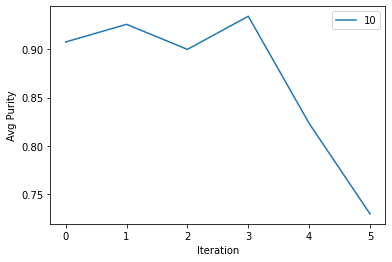

In [53]:
import matplotlib.pyplot as plt
# plt.plot(range(6), avg_purities[1:], label="VarTN")
plt.plot(range(6), confidences, label="10")

plt.legend()

plt.xlabel("Iteration")
plt.ylabel("Avg Purity")

In [21]:
avg_purities[1:]

/home/jagaskak/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[45.64355568004036,
 0.892394016177775,
 13.521302074318882,
 2.904940554533141,
 10.442655944485722,
 21.84108674155414]